In [40]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset, randomRotation3D

import torch
from torch import nn
import torchvision.transforms as T

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')

p=0.3
batch_size = 4
num_gpus = 2
subtomo_length = 128

transform = randomRotation3D(0.5)

my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=8, transform=transform)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Size of dataset: 32, Steps per epoch: 4


In [42]:
idx = 0
subtomo, target, mask = my_dataset[idx]
subtomo.shape

torch.Size([1, 128, 128, 128])

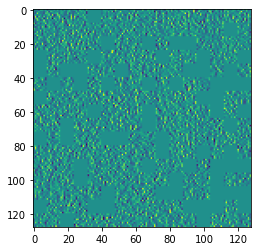

In [45]:
zidx = subtomo_length//2
plt.imshow(subtomo.squeeze()[zidx])

In [25]:
my_dataset.create_Pmask().shape, my_dataset.create_Vmask().shape

(torch.Size([1, 128, 128, 128]), torch.Size([1, 128, 128, 128]))